In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For better date formatting
import openpyxl 
import numpy as np


--- Processing Neo Bank: Neo Banks Price History/All Neo Banks PH.xlsx ---
Successfully calculated Neo Bank Index.

--- Processing Challenger Bank: Challenger Banks Price History/All Challenger Banks PH.xlsx ---
Successfully calculated Challenger Bank Index.

--- Processing Traditional Bank: Traditional Banks Price History/All Traditional Banks.xlsx ---
Successfully calculated Traditional Bank Index.

--- Latest individual index start date is: 2017-01-02 ---
--- Aligning all indices to first common valid date: 2017-01-03 ---

--- Aligned and Re-based Index Comparison (First 5 rows) ---
            Neo Bank Index  Challenger Bank Index  Traditional Bank Index
Date                                                                     
2017-01-03      100.000000             100.000000              100.000000
2017-01-04      102.753085             100.352207              101.260313
2017-01-05      103.814760             101.145584              101.172694
2017-01-06      104.296620          

C:\Users\James\AppData\Local\Temp\ipykernel_33664\416440161.py:125: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = indices_df.resample('M').last().dropna(how='all')


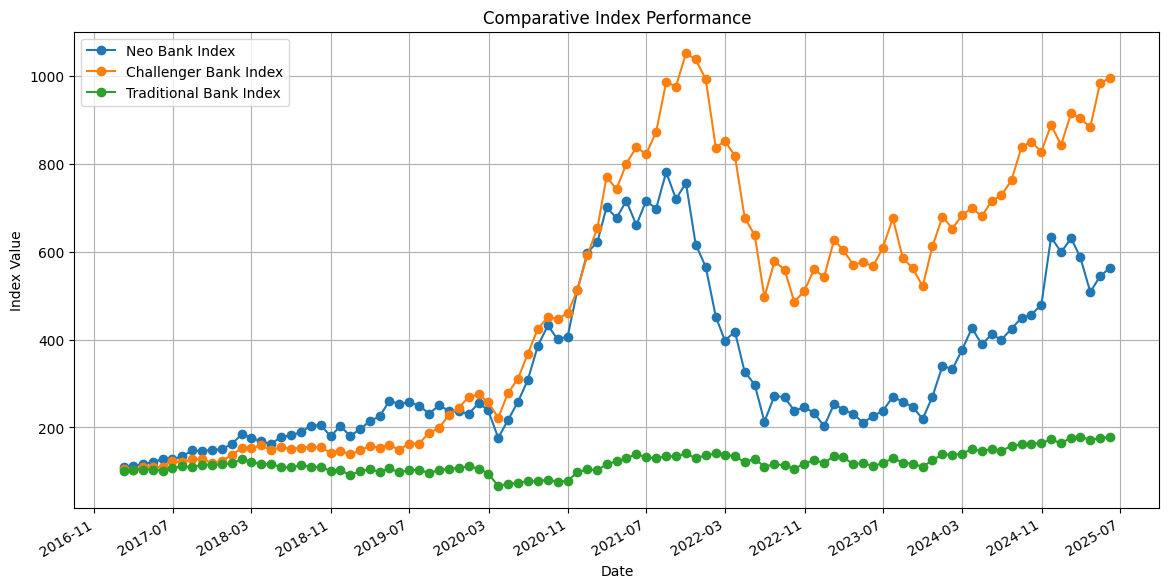


--- Script Finished ---


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For better date formatting
import openpyxl
import numpy as np


# --- Function Definitions ---
# (All function definitions should be placed here, before the main script)

def load_and_prepare_data(filepath, sheet_name=0):
    """
    Loads data from a single Excel file, and prepares it.
    Each pair of (Exchange Date, Price) columns is treated as a separate company.
    """
    try:
        xls = pd.ExcelFile(filepath)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame(), [] # Return empty DataFrame and list
    df_raw = pd.read_excel(xls, sheet_name=sheet_name, header=0)

    all_company_data = []
    company_names = []

    if df_raw.shape[1] % 2 != 0:
        print(f"Warning: The Excel file {filepath} has an odd number of columns. Expecting Date/Price pairs.")
        # Process pairs and ignore the last column if odd.

    # Iterate through columns ensuring we don't go out of bounds for price_col_name
    for i in range(0, df_raw.shape[1] - (df_raw.shape[1] % 2) , 2):
        date_col_name = df_raw.columns[i]
        price_col_name = df_raw.columns[i+1]
        company_name = price_col_name # Assuming price column header is the company name

        company_df = df_raw[[date_col_name, price_col_name]].copy()
        company_df.columns = ['Date', 'Price'] # Standardize column names

        # Convert 'Date' column to datetime objects, handling potential errors
        company_df['Date'] = pd.to_datetime(company_df['Date'], errors='coerce')
        company_df.dropna(subset=['Date'], inplace=True) # Remove rows where date conversion failed

        # Remove rows where Price might be missing (e.g., before IPO) or non-numeric
        company_df['Price'] = pd.to_numeric(company_df['Price'], errors='coerce')
        company_df.dropna(subset=['Price'], inplace=True)

        if company_df.empty:
            continue

        company_df.set_index('Date', inplace=True)
        company_df.rename(columns={'Price': company_name}, inplace=True)

        if not company_df.empty:
            all_company_data.append(company_df)
            company_names.append(company_name)

    if not all_company_data:
        return pd.DataFrame(), []

    merged_df = pd.concat(all_company_data, axis=1, join='outer')
    merged_df.sort_index(inplace=True)
    return merged_df, company_names

def calculate_equal_weighted_index(price_data_df, base_value=100):
    """
    Calculates an equal-weighted index.
    """
    if price_data_df.empty:
        return pd.Series(dtype=float), pd.DataFrame(dtype=float), pd.DataFrame(dtype=float), pd.Series(dtype=int)

    filled_price_data = price_data_df.ffill()
    daily_returns = filled_price_data.pct_change()
    num_companies_active = filled_price_data.notna().sum(axis=1)
    index_daily_returns = daily_returns.mean(axis=1)

    first_valid_date = None
    if not num_companies_active[num_companies_active > 0].empty:
        first_valid_date = num_companies_active[num_companies_active > 0].index[0]
        index_daily_returns.loc[first_valid_date] = 0
    else:
        return pd.Series(dtype=float), daily_returns, filled_price_data, num_companies_active

    index_values = base_value * (1 + index_daily_returns).cumprod()
    index_values = index_values.reindex(filled_price_data.index)

    if first_valid_date:
        if not index_values.empty and index_values.index[0] < first_valid_date:
             index_values.loc[:pd.Timestamp(first_valid_date) - pd.Timedelta(days=1)] = float('nan')
        if first_valid_date in index_values.index:
            index_values.loc[first_valid_date] = base_value
    else:
        index_values[:] = float('nan')

    return index_values, daily_returns, filled_price_data, num_companies_active

def process_and_return_index(file_path_to_process, index_name_prefix):
    """
    Loads data, calculates index, and returns it for later use.
    This version is simplified to only return the index series.
    """
    print(f"\n--- Processing {index_name_prefix}: {file_path_to_process} ---")
    combined_prices_df, _ = load_and_prepare_data(file_path_to_process)

    if not combined_prices_df.empty:
        index_series, _, _, _ = calculate_equal_weighted_index(combined_prices_df, base_value=100)
        if not index_series.dropna().empty:
            print(f"Successfully calculated {index_name_prefix} Index.")
            return index_series.rename(f"{index_name_prefix} Index") # Rename for clarity
        else:
            print(f"Index calculation for {index_name_prefix} resulted in no valid data.")
            return None
    else:
        print(f"No data loaded from {file_path_to_process}.")
        return None

def plot_multiple_indices(indices_df, title='Comparative Index Performance'):
    """
    Plots multiple index series from a DataFrame on the same monthly chart.
    """
    if indices_df.empty:
        print("DataFrame is empty. Cannot plot.")
        return

    # Resample to monthly, using the last value of the month
    monthly_df = indices_df.resample('M').last().dropna(how='all')

    if monthly_df.empty:
        print("No data available for monthly plotting after resampling.")
        return

    plt.figure(figsize=(14, 7))
    for column in monthly_df.columns:
        plt.plot(monthly_df.index, monthly_df[column], marker='o', linestyle='-', label=column)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.grid(True)
    plt.legend() # Add a legend to distinguish the lines

    # Formatting the x-axis for dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    locator_interval = max(1, len(monthly_df) // 12 if len(monthly_df) > 0 else 1)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=locator_interval))
    plt.gcf().autofmt_xdate()

    plt.show()


# --- Main Script (Revised for Robust Comparison) ---
# This block runs after all functions above have been defined.

# 1. Define your file paths
# IMPORTANT: Replace these with the actual paths to your Excel files.
file_path1_neo = r'Neo Banks Price History/All Neo Banks PH.xlsx'
file_path2_challenger = r'Challenger Banks Price History/All Challenger Banks PH.xlsx'
file_path3_traditional = r'Traditional Banks Price History/All Traditional Banks.xlsx'

# 2. Process each file to calculate its index series
neo_index = process_and_return_index(file_path1_neo, "Neo Bank")
challenger_index = process_and_return_index(file_path2_challenger, "Challenger Bank")
traditional_index = process_and_return_index(file_path3_traditional, "Traditional Bank")

# 3. Collect all successfully calculated indices into a list
indices = [idx for idx in [neo_index, challenger_index, traditional_index] if idx is not None]

# 4. Proceed only if there are at least two indices to compare
if len(indices) < 2:
    print("\n--- Comparison requires at least two valid indices. Script finished. ---")
else:
    # 5. Find the latest start date among all individual indices
    latest_start_date = max([idx.first_valid_index() for idx in indices])
    print(f"\n--- Latest individual index start date is: {latest_start_date.date()} ---")

    # 6. Combine all original indices into one DataFrame for alignment
    temp_df = pd.concat(indices, axis=1)

    # 7. Slice the combined frame from the latest start date onwards
    sliced_df = temp_df.loc[latest_start_date:]

    # 8. Find the first date where ALL indices have valid data by dropping any row with a NaN
    # This is the key step to handle non-trading days.
    first_common_date = sliced_df.dropna().index[0]
    print(f"--- Aligning all indices to first common valid date: {first_common_date.date()} ---")

    # 9. Slice again from this truly common start date
    final_slice_df = sliced_df.loc[first_common_date:]

    # 10. Re-base the entire DataFrame using the values in its first row
    first_row_values = final_slice_df.iloc[0]
    comparison_df = (final_slice_df / first_row_values) * 100

    print("\n--- Aligned and Re-based Index Comparison (First 5 rows) ---")
    print(comparison_df.head())

    # 11. Plot the comparative performance on a single chart
    plot_multiple_indices(comparison_df, title='Comparative Index Performance')

    # Optional: Save the combined, aligned data to a single Excel file
    # comparison_df.to_excel('compared_indices.xlsx')
    # print("\nComparison data saved to compared_indices.xlsx")

print("\n--- Script Finished ---")

--- Loading pre-calculated indices from: calculated_indices.xlsx ---
Successfully loaded sheet: 'Neo Bank Index'
Successfully loaded sheet: 'Challenger Bank Index'
Successfully loaded sheet: 'Traditional Bank Index'

--- Aligning all indices to first common valid date: 2017-01-03 ---
--- Truncating all data to end on or before: 2025-05-01 ---

--- Aligned and Re-based Index Comparison (First 5 rows) ---
            Neo Bank Index  Challenger Bank Index  Traditional Bank Index
Date                                                                     
2017-01-03      100.000000             100.000000              100.000000
2017-01-04      102.753085             100.352207              101.260313
2017-01-05      103.814760             101.145584              101.172694
2017-01-06      104.296620             100.434931              101.321177
2017-01-09      104.339926              99.587078              100.750616


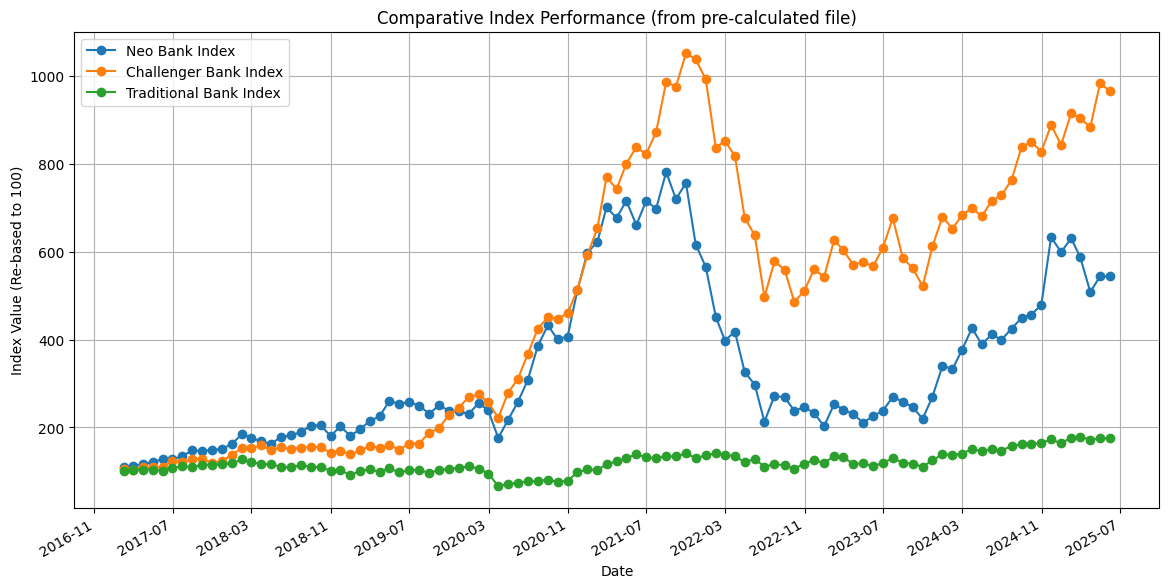


--- Generating individual plots from 2017-01-03 to 2025-05-01 ---
Standardizing individual plot Y-axis from 20.36 to 1166.29


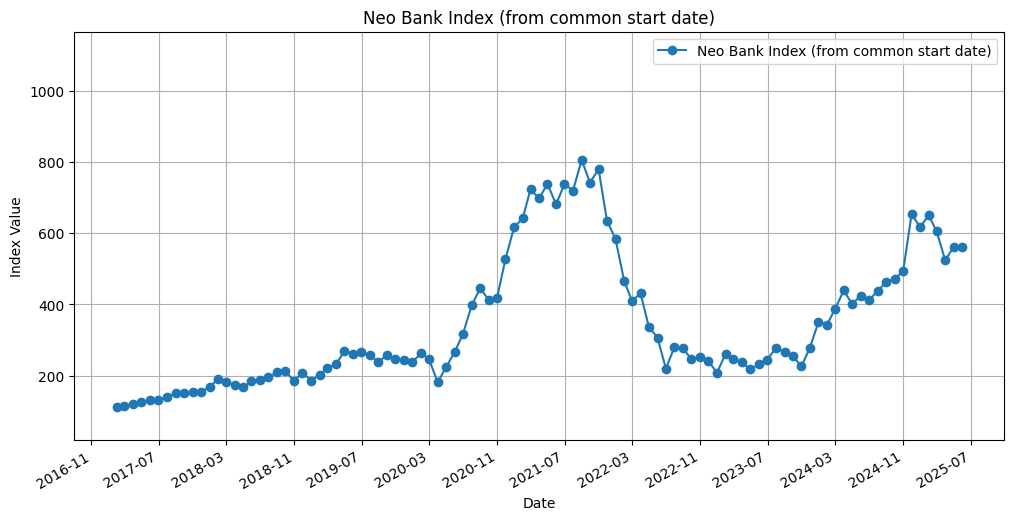

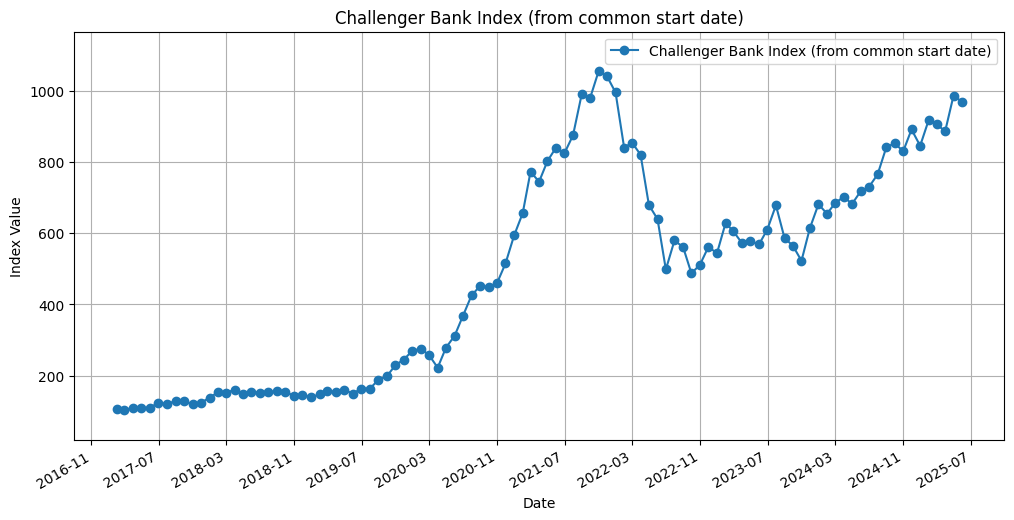

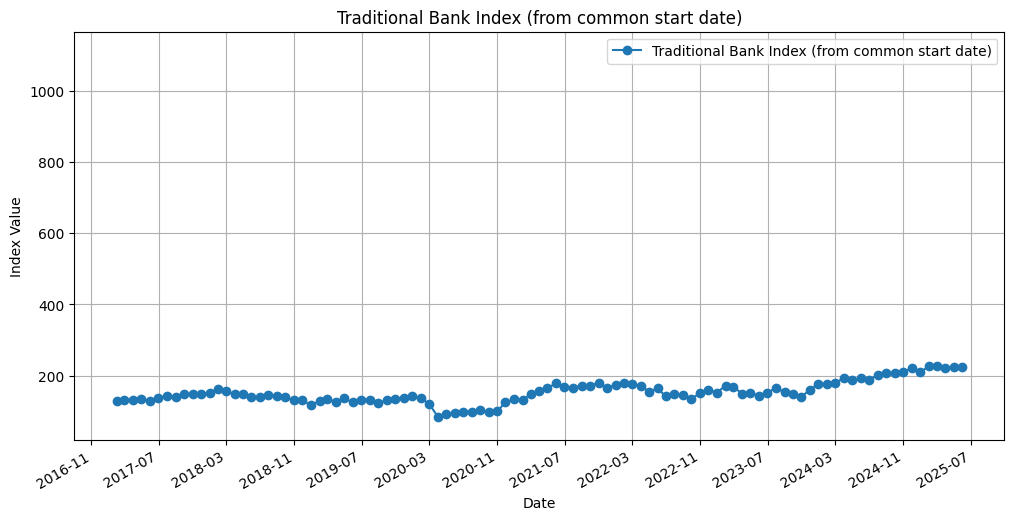


--- Script Finished ---


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Function Definitions ---

# MODIFIED FUNCTION: Added a 'y_limits' parameter to accept a standardized range.
def plot_single_index(index_series, title='Index Performance', y_limits=None):
    """
    Plots a single index on its own monthly chart.
    If y_limits (a tuple) is provided, it sets a fixed y-axis range.
    """
    if index_series.empty or index_series.dropna().empty:
        print(f"Index series '{title}' is empty or all NaN after date filtering. Cannot plot.")
        return

    try:
        monthly_series = index_series.resample('ME').last().dropna()
    except AttributeError:
        monthly_series = index_series.resample('M').last().dropna()

    if monthly_series.empty:
        print(f"No data available for monthly plotting for '{title}'.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(monthly_series.index, monthly_series.values, marker='o', linestyle='-', label=title)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.grid(True)
    plt.legend()
    
    # This is the new part: Apply the standardized y-axis limits if they are provided.
    if y_limits:
        plt.ylim(y_limits)
        
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    locator_interval = max(1, len(monthly_series) // 12 if len(monthly_series) > 0 else 1)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=locator_interval))
    plt.gcf().autofmt_xdate()
    plt.show()

def plot_multiple_indices(indices_df, title='Comparative Index Performance'):
    """
    Plots multiple index series from a DataFrame on the same monthly chart.
    """
    if indices_df.empty:
        print("DataFrame is empty after date filtering. Cannot plot.")
        return

    try:
        monthly_df = indices_df.resample('ME').last().dropna(how='all')
    except AttributeError:
        monthly_df = indices_df.resample('M').last().dropna(how='all')

    if monthly_df.empty:
        print("No data available for monthly plotting after resampling.")
        return

    plt.figure(figsize=(14, 7))
    for column in monthly_df.columns:
        plt.plot(monthly_df.index, monthly_df[column], marker='o', linestyle='-', label=column)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Index Value (Re-based to 100)')
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    locator_interval = max(1, len(monthly_df) // 12 if len(monthly_df) > 0 else 1)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=locator_interval))
    plt.gcf().autofmt_xdate()
    plt.show()

# --- Main Script ---

# 1. DEFINE YOUR PARAMETERS HERE
file_path = "calculated_indices.xlsx"
sheet_names = ["Neo Bank Index", "Challenger Bank Index", "Traditional Bank Index"]
hard_stop_date = pd.to_datetime('2025-05-01')

print(f"--- Loading pre-calculated indices from: {file_path} ---")

# 2. Load each index
loaded_indices = []
try:
    for sheet in sheet_names:
        index_series = pd.read_excel(file_path, sheet_name=sheet, index_col=0, parse_dates=True).iloc[:, 0]
        index_series.name = sheet
        loaded_indices.append(index_series)
        print(f"Successfully loaded sheet: '{sheet}'")
except FileNotFoundError:
    print(f"\nERROR: The file was not found at the specified path.")
    exit()
except Exception as e:
    print(f"\nAn error occurred while reading the Excel file: {e}")
    exit()

# 3. Proceed only if data was loaded
if not loaded_indices or len(loaded_indices) < 2:
    print("\n--- At least two indices are required for comparison. Script finished. ---")
else:
    # --- Part 1: Generate the Comparative Chart ---
    temp_df = pd.concat(loaded_indices, axis=1)
    first_common_date = temp_df.dropna().index[0]
    print(f"\n--- Aligning all indices to first common valid date: {first_common_date.date()} ---")
    print(f"--- Truncating all data to end on or before: {hard_stop_date.date()} ---")

    final_slice_df = temp_df.loc[first_common_date:hard_stop_date]
    comparison_df = (final_slice_df / final_slice_df.iloc[0]) * 100

    print("\n--- Aligned and Re-based Index Comparison (First 5 rows) ---")
    print(comparison_df.head())
    plot_multiple_indices(comparison_df, title=f'Comparative Index Performance (from pre-calculated file)')

    # --- Part 2: Generate Individual Charts with Standardized Y-Axis ---
    print(f"\n--- Generating individual plots from {first_common_date.date()} to {hard_stop_date.date()} ---")
    
    # NEW: Calculate the common y-axis range BEFORE plotting.
    # 1. Get the slice of data that will be plotted.
    individual_plots_df = temp_df.loc[first_common_date:hard_stop_date]
    
    # 2. Find the absolute min and max across all data in that slice.
    global_min = individual_plots_df.min().min()
    global_max = individual_plots_df.max().max()
    
    # 3. Add 5% padding for better visualization.
    padding = (global_max - global_min) * 0.05
    y_axis_limits = (global_min - padding, global_max + padding)
    
    print(f"Standardizing individual plot Y-axis from {y_axis_limits[0]:.2f} to {y_axis_limits[1]:.2f}")

    # Loop through the columns of our sliced dataframe.
    for index_name in individual_plots_df.columns:
        # Pass the calculated y_axis_limits to the plotting function.
        plot_single_index(
            individual_plots_df[index_name], 
            title=f"{index_name} (from common start date)",
            y_limits=y_axis_limits
        )
        
print("\n--- Script Finished ---")

In [4]:
def load_and_prepare_data(filepath, sheet_name=0):
    """
    Loads data from a single Excel file, and prepares it.
    Each pair of (Exchange Date, Price) columns is treated as a separate company.
    """
    try:
        xls = pd.ExcelFile(filepath)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame(), [] # Return empty DataFrame and list
    df_raw = pd.read_excel(xls, sheet_name=sheet_name, header=0)

    all_company_data = []
    company_names = []

    if df_raw.shape[1] % 2 != 0:
        print(f"Warning: The Excel file {filepath} has an odd number of columns. Expecting Date/Price pairs.")
        # Process pairs and ignore the last column if odd.

    # Iterate through columns ensuring we don't go out of bounds for price_col_name
    for i in range(0, df_raw.shape[1] - (df_raw.shape[1] % 2) , 2):
        date_col_name = df_raw.columns[i]
        price_col_name = df_raw.columns[i+1]
        company_name = price_col_name # Assuming price column header is the company name

        company_df = df_raw[[date_col_name, price_col_name]].copy()
        company_df.columns = ['Date', 'Price'] # Standardize column names

        # Convert 'Date' column to datetime objects, handling potential errors
        company_df['Date'] = pd.to_datetime(company_df['Date'], errors='coerce')
        company_df.dropna(subset=['Date'], inplace=True) # Remove rows where date conversion failed

        # Remove rows where Price might be missing (e.g., before IPO) or non-numeric
        company_df['Price'] = pd.to_numeric(company_df['Price'], errors='coerce')
        company_df.dropna(subset=['Price'], inplace=True)

        if company_df.empty:
            # print(f"No valid data for columns {date_col_name}/{price_col_name} in {filepath}") # Can be verbose
            continue

        company_df.set_index('Date', inplace=True)
        company_df.rename(columns={'Price': company_name}, inplace=True)

        if not company_df.empty:
            all_company_data.append(company_df)
            company_names.append(company_name)

    if not all_company_data:
        # print(f"No company data successfully processed from {filepath}") # Can be verbose
        return pd.DataFrame(), []

    merged_df = pd.concat(all_company_data, axis=1, join='outer')
    merged_df.sort_index(inplace=True)
    return merged_df, company_names

def calculate_equal_weighted_index(price_data_df, base_value=100):
    """
    Calculates an equal-weighted index.
    """
    if price_data_df.empty:
        # print("Cannot calculate index from empty price data.") # Can be verbose
        # Return empty structures that downstream functions expect
        return pd.Series(dtype=float), pd.DataFrame(dtype=float), pd.DataFrame(dtype=float), pd.Series(dtype=int)

    filled_price_data = price_data_df.ffill()
    daily_returns = filled_price_data.pct_change()
    num_companies_active = filled_price_data.notna().sum(axis=1)
    index_daily_returns = daily_returns.mean(axis=1) # Auto handles NaNs for equal weighting

    first_valid_date = None
    if not num_companies_active[num_companies_active > 0].empty:
        first_valid_date = num_companies_active[num_companies_active > 0].index[0]
        index_daily_returns.loc[first_valid_date] = 0 # Set initial return to 0 for the base day
    else: # Handle case where there's no valid data at all
        # print("No active companies found to calculate index.") # Can be verbose
        return pd.Series(dtype=float), daily_returns, filled_price_data, num_companies_active

    index_values = base_value * (1 + index_daily_returns).cumprod()
    index_values = index_values.reindex(filled_price_data.index) # Align index with original dates

    if first_valid_date:
        # Set NaNs for dates before any stock was active
        if not index_values.empty and index_values.index[0] < first_valid_date:
             index_values.loc[:pd.Timestamp(first_valid_date) - pd.Timedelta(days=1)] = float('nan')
        # Ensure the first valid date starts exactly at base_value
        if first_valid_date in index_values.index:
            index_values.loc[first_valid_date] = base_value
    else: # If no valid date, the whole series should be NaN
        index_values[:] = float('nan')

    return index_values, daily_returns, filled_price_data, num_companies_active

def plot_monthly_index(index_series, title='Monthly Index Performance'):
    """
    Plots the index performance on a monthly basis.
    Uses the last available index value of each month.
    """
    if index_series.empty or index_series.dropna().empty:
        print(f"Index series for '{title}' is empty or contains all NaNs. Cannot plot.")
        return

    monthly_index = index_series.resample('M').last() # 'M' stands for month-end frequency
    monthly_index = monthly_index.dropna()

    if monthly_index.empty:
        print(f"No data available for monthly plotting for '{title}' after resampling and dropping NaNs.")
        return

    plt.figure(figsize=(12, 6)) # Create a new figure for each plot
    plt.plot(monthly_index.index, monthly_index.values, marker='o', linestyle='-')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.grid(True)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    locator_interval = max(1, len(monthly_index) // 12 if len(monthly_index) > 0 else 1)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=locator_interval))
    plt.gcf().autofmt_xdate()

    plt.show()

def process_and_display_index(file_path_to_process, index_name_prefix):
    """
    Loads data, calculates index, prints info, and plots for a given file.
    """
    print(f"\n--- Processing {index_name_prefix}: {file_path_to_process} ---")
    combined_prices_df, _ = load_and_prepare_data(file_path_to_process)

    if not combined_prices_df.empty:
        print(f"--- {index_name_prefix}: Combined and Aligned Price Data (Head) ---")
        print(combined_prices_df.head())

        bank_index, _, _, _ = calculate_equal_weighted_index(combined_prices_df, base_value=100)

        if not bank_index.dropna().empty: # Check if index calculation resulted in valid data
            print(f"\n--- {index_name_prefix}: Calculated Index (First 5 values) ---")
            print(bank_index.head())
            print(f"\n--- {index_name_prefix}: Calculated Index (Last 5 values) ---")
            print(bank_index.tail())

            plot_monthly_index(bank_index, title=f'{index_name_prefix} Index - Monthly Performance')

            # Optional: Save the index to a new Excel file
            # file_name_safe_prefix = index_name_prefix.lower().replace(" ", "_")
            # bank_index_df = pd.DataFrame(bank_index, columns=[f'{index_name_prefix}Index'])
            # bank_index_df.to_excel(f'{file_name_safe_prefix}_index.xlsx')
            # print(f"\n{index_name_prefix} Index saved to {file_name_safe_prefix}_index.xlsx")
        else:
            print(f"Index calculation for {index_name_prefix} resulted in no valid data (all NaNs).")
    else:
        print(f"No data loaded from {file_path_to_process}. Skipping {index_name_prefix} Index calculation and plot.")



--- Processing Neo Bank: Neo Banks Price History/All Neo Banks PH.xlsx ---
--- Neo Bank: Combined and Aligned Price Data (Head) ---
            DAVE       ZIP  WISE  RELY   PYPL  PSFE  NWL  MQ  MOGO    MELI  \
Date                                                                         
2016-12-30   NaN       NaN   NaN   NaN    NaN   NaN  NaN NaN   NaN  156.14   
2017-01-03   NaN  0.570698   NaN   NaN  40.25   NaN  NaN NaN   NaN  161.02   
2017-01-04   NaN  0.575357   NaN   NaN  41.00   NaN  NaN NaN   NaN  165.82   
2017-01-05   NaN  0.579544   NaN   NaN  41.06   NaN  NaN NaN   NaN  171.28   
2017-01-06   NaN       NaN   NaN   NaN  41.45   NaN  NaN NaN   NaN  172.16   

               LC  HOOD   GDOT  FOUR  COIN  BILL  AFRM  ML  
Date                                                        
2016-12-30    NaN   NaN    NaN   NaN   NaN   NaN   NaN NaN  
2017-01-03  27.10   NaN  23.63   NaN   NaN   NaN   NaN NaN  
2017-01-04  28.70   NaN  24.15   NaN   NaN   NaN   NaN NaN  
2017-01-05  28.

C:\Users\James\AppData\Local\Temp\ipykernel_33664\192414631.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index = index_series.resample('M').last() # 'M' stands for month-end frequency


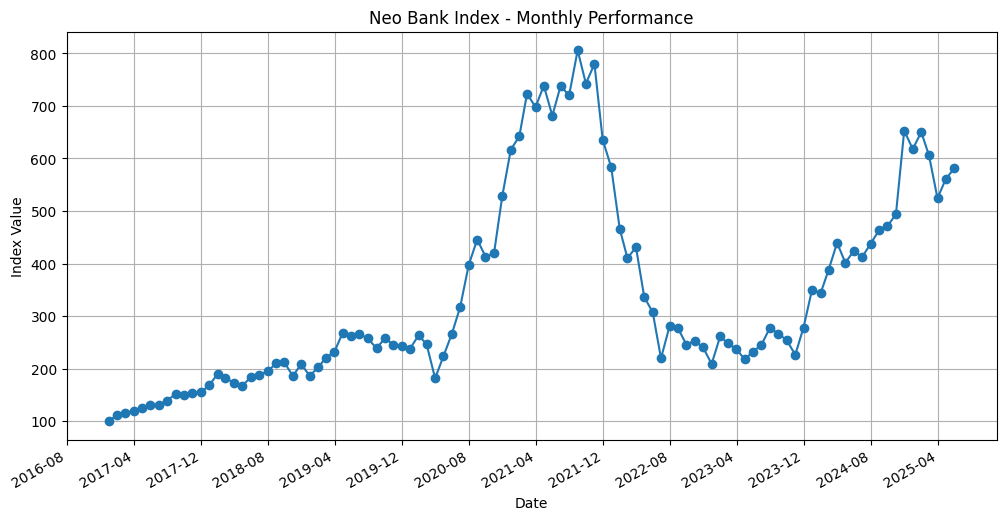


--- Processing Challenger Bank: Challenger Banks Price History/All Challenger Banks PH.xlsx ---
--- Challenger Bank: Combined and Aligned Price Data (Head) ---
            TYR        SQN  SOFI  SE  Close  SAVE  RAKUTEN  Close.1  KAKAO  \
Date                                                                         
2017-01-02  NaN        NaN   NaN NaN    NaN   NaN      NaN      NaN    NaN   
2017-01-03  NaN  23.663453   NaN NaN    NaN   NaN      NaN      NaN    NaN   
2017-01-04  NaN  23.725490   NaN NaN    NaN   NaN      NaN      NaN    NaN   
2017-01-05  NaN  24.571485   NaN NaN    NaN   NaN      NaN      NaN    NaN   
2017-01-06  NaN  24.167403   NaN NaN    NaN   NaN      NaN      NaN    NaN   

            JDO  INTR  ILTY  GRAB       FBK      DSYJ      BBYB     AX  \
Date                                                                     
2017-01-02  NaN   NaN   NaN   NaN  5.740876       NaN       NaN    NaN   
2017-01-03  NaN   NaN   NaN   NaN  5.664971  8.343581  0.022614  28.40

C:\Users\James\AppData\Local\Temp\ipykernel_33664\192414631.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index = index_series.resample('M').last() # 'M' stands for month-end frequency


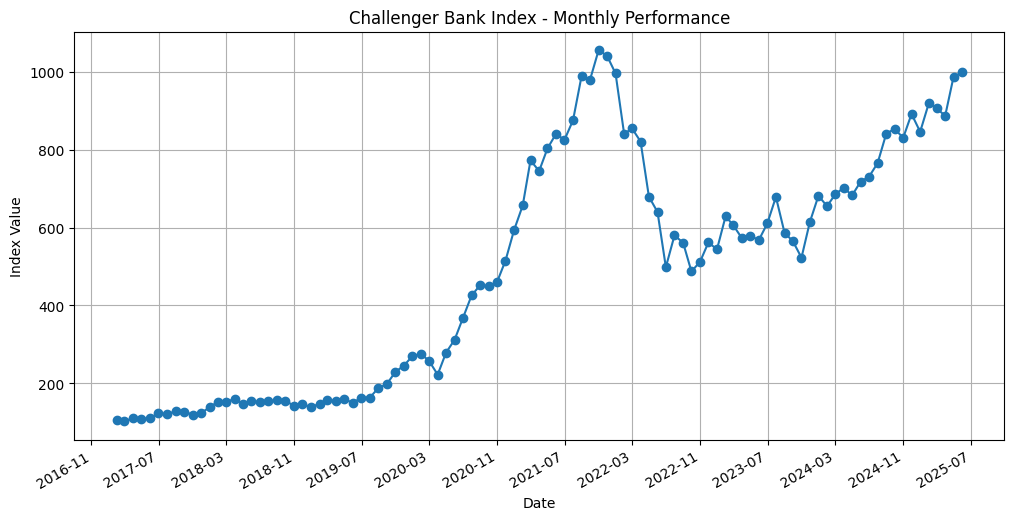


--- Processing Traditional Bank: Traditional Banks Price History/All Traditional Banks.xlsx ---
--- Traditional Bank: Combined and Aligned Price Data (Head) ---
             ALLY     BK    BMO      C    CFG        COF    FITB      GS  \
Date                                                                       
2016-01-04  18.65  39.97  55.04  51.13  25.80  70.479889  19.550  177.14   
2016-01-05  18.62  39.82  54.77  50.86  25.68  69.204596  19.610  174.09   
2016-01-06  18.32  38.82  53.19  50.12  25.28  68.297942  19.320  169.84   
2016-01-07  17.41  37.84  52.15  47.56  24.59  64.840701  18.710  164.62   
2016-01-08  16.88  37.15  51.94  46.13  23.82  63.993826  18.385  163.94   

             HBAN    JPM  ...  BBVA  BNPP  CAGR  CRDI  HSBA   INGA  LLOY  SAN  \
Date                      ...                                                   
2016-01-04  10.70  63.62  ...   NaN   NaN   NaN   NaN   NaN    NaN   NaN  NaN   
2016-01-05  10.72  63.73  ...   NaN   NaN   NaN   NaN   NaN   

C:\Users\James\AppData\Local\Temp\ipykernel_33664\192414631.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index = index_series.resample('M').last() # 'M' stands for month-end frequency


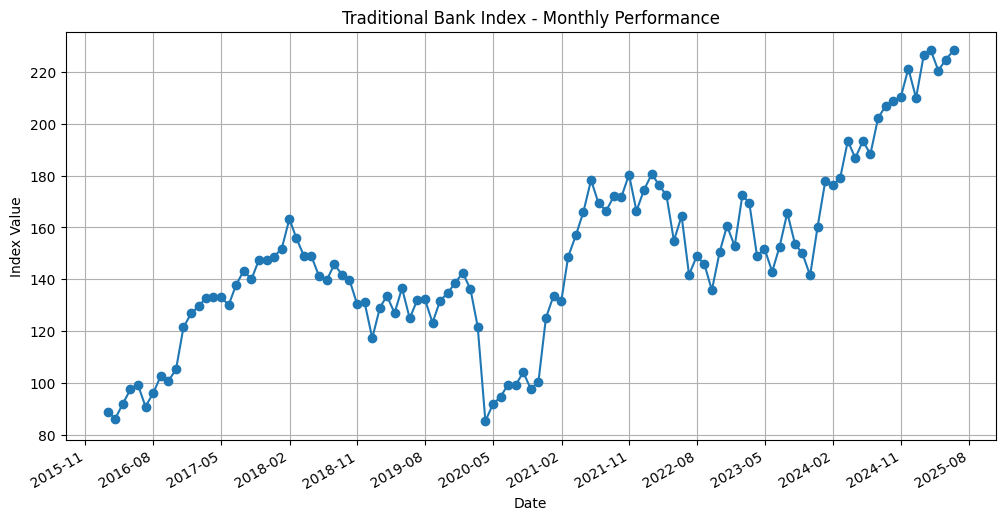


--- Script Finished ---


In [5]:
# --- Main Script ---

# Define your file paths
# IMPORTANT: Replace these with the actual paths to your Excel files.
# Use raw strings (r'...') for Windows paths if they contain backslashes,
# or use forward slashes.
file_path1_neo = r'Neo Banks Price History/All Neo Banks PH.xlsx'
file_path2_challenger = r'Challenger Banks Price History/All Challenger Banks PH.xlsx'
file_path3_traditional = r'Traditional Banks Price History/All Traditional Banks.xlsx'

# Process the first file
process_and_display_index(file_path1_neo, "Neo Bank")

# Process the second file
process_and_display_index(file_path2_challenger, "Challenger Bank")

process_and_display_index(file_path3_traditional, "Traditional Bank")

print("\n--- Script Finished ---")

In [6]:
def process_and_return_index(file_path_to_process, index_name_prefix):
    """
    Loads data, calculates index, and returns it for later use.
    This version is simplified to only return the index series.
    """
    print(f"\n--- Processing {index_name_prefix}: {file_path_to_process} ---")
    combined_prices_df, _ = load_and_prepare_data(file_path_to_process)

    if not combined_prices_df.empty:
        index_series, _, _, _ = calculate_equal_weighted_index(combined_prices_df, base_value=100)
        if not index_series.dropna().empty:
            print(f"Successfully calculated {index_name_prefix} Index.")
            return index_series.rename(f"{index_name_prefix} Index") # Rename for clarity in Excel
        else:
            print(f"Index calculation for {index_name_prefix} resulted in no valid data.")
            return None
    else:
        print(f"No data loaded from {file_path_to_process}.")
        return None

In [7]:
# --- Main Script to Calculate and Save Indices ---

# Define file paths
file_path1_neo = r'Neo Banks Price History/All Neo Banks PH.xlsx'
file_path2_challenger = r'Challenger Banks Price History/All Challenger Banks PH.xlsx'
file_path3_traditional = r'Traditional Banks Price History/All Traditional Banks.xlsx'

# Calculate all indices
neo_index = process_and_return_index(file_path1_neo, "Neo Bank")
challenger_index = process_and_return_index(file_path2_challenger, "Challenger Bank")
traditional_index = process_and_return_index(file_path3_traditional, "Traditional Bank")

# Save the calculated indices to a single Excel file
output_excel_path = 'calculated_indices.xlsx'
with pd.ExcelWriter(output_excel_path) as writer:
    if neo_index is not None:
        neo_index.to_excel(writer, sheet_name='Neo Bank Index')
        print("\nNeo Bank Index saved to sheet 'Neo Bank Index'")
    if challenger_index is not None:
        challenger_index.to_excel(writer, sheet_name='Challenger Bank Index')
        print("Challenger Bank Index saved to sheet 'Challenger Bank Index'")
    if traditional_index is not None:
        traditional_index.to_excel(writer, sheet_name='Traditional Bank Index')
        print("Traditional Bank Index saved to sheet 'Traditional Bank Index'")

print(f"\n--- All indices saved to {output_excel_path} ---")


--- Processing Neo Bank: Neo Banks Price History/All Neo Banks PH.xlsx ---
Successfully calculated Neo Bank Index.

--- Processing Challenger Bank: Challenger Banks Price History/All Challenger Banks PH.xlsx ---
Successfully calculated Challenger Bank Index.

--- Processing Traditional Bank: Traditional Banks Price History/All Traditional Banks.xlsx ---
Successfully calculated Traditional Bank Index.

Neo Bank Index saved to sheet 'Neo Bank Index'
Challenger Bank Index saved to sheet 'Challenger Bank Index'
Traditional Bank Index saved to sheet 'Traditional Bank Index'

--- All indices saved to calculated_indices.xlsx ---


In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_stationarity_tests(series, series_name):
    """
    Runs and interprets the Augmented Dickey-Fuller and KPSS tests on a time series.
    """
    print(f"\n--- Stationarity Tests for {series_name} ---")

    # Drop missing values for the tests
    series_cleaned = series.dropna()

    # --- Augmented Dickey-Fuller Test ---
    # The ADF test checks for non-stationarity.
    # Null Hypothesis (H0): The series has a unit root (it is non-stationary).
    # Alternative Hypothesis (HA): The series does not have a unit root (it is stationary).
    print("\n1. Augmented Dickey-Fuller Test (ADF):")
    # The adfuller function returns several values; we're primarily interested in the p-value.
    adf_result = adfuller(series_cleaned)
    p_value_adf = adf_result[1]

    print(f"   ADF Statistic: {adf_result[0]}")
    print(f"   p-value: {p_value_adf}")
    print("   Critical Values:")
    for key, value in adf_result[4].items():
        print(f'      {key}: {value}')

    if p_value_adf <= 0.05:
        print("\n   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).")
        print("   Reject the null hypothesis. The series is likely stationary.")
    else:
        print("\n   Conclusion: Weak evidence against the null hypothesis (p > 0.05).")
        print("   Fail to reject the null hypothesis. The series is likely non-stationary.")

    # --- KPSS Test ---
    # The KPSS test checks for stationarity around a mean or trend.
    # Null Hypothesis (H0): The series is stationary around a constant (trend-stationary).
    # Alternative Hypothesis (HA): The series has a unit root (it is not stationary).
    print("\n2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):")
    # We use 'ct' to test for stationarity around a trend, which is common for financial indices.
    kpss_result = kpss(series_cleaned, regression='ct')
    p_value_kpss = kpss_result[1]

    print(f"   KPSS Statistic: {kpss_result[0]}")
    print(f"   p-value: {p_value_kpss}")
    print("   Critical Values:")
    for key, value in kpss_result[3].items():
        print(f'      {key}: {value}')

    if p_value_kpss <= 0.05:
        print("\n   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).")
        print("   Reject the null hypothesis. The series is likely non-stationary.")
    else:
        print("\n   Conclusion: Weak evidence against the null hypothesis (p > 0.05).")
        print("   Fail to reject the null hypothesis. The series is likely trend-stationary.")

# --- Main Script to Load and Test Indices ---
excel_file_path = 'calculated_indices.xlsx'
try:
    # Load each sheet into a separate DataFrame
    neo_index_df = pd.read_excel(excel_file_path, sheet_name='Neo Bank Index', index_col=0)
    challenger_index_df = pd.read_excel(excel_file_path, sheet_name='Challenger Bank Index', index_col=0)
    traditional_index_df = pd.read_excel(excel_file_path, sheet_name='Traditional Bank Index', index_col=0)

    # Extract the series from the DataFrames
    neo_series = neo_index_df.iloc[:, 0]
    challenger_series = challenger_index_df.iloc[:, 0]
    traditional_series = traditional_index_df.iloc[:, 0]

    # Run tests for each index
    run_stationarity_tests(neo_series, "Neo Bank Index")
    run_stationarity_tests(challenger_series, "Challenger Bank Index")
    run_stationarity_tests(traditional_series, "Traditional Bank Index")

except FileNotFoundError:
    print(f"Error: The file '{excel_file_path}' was not found.")
    print("Please make sure you have run the first code block to generate it.")


--- Stationarity Tests for Neo Bank Index ---

1. Augmented Dickey-Fuller Test (ADF):
   ADF Statistic: -1.3304513180443702
   p-value: 0.6151282429028542
   Critical Values:
      1%: -3.433419473570619
      5%: -2.862895974588963
      10%: -2.5674918550982277

   Conclusion: Weak evidence against the null hypothesis (p > 0.05).
   Fail to reject the null hypothesis. The series is likely non-stationary.

2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):
   KPSS Statistic: 0.6839364229704246
   p-value: 0.01
   Critical Values:
      10%: 0.119
      5%: 0.146
      2.5%: 0.176
      1%: 0.216

   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).
   Reject the null hypothesis. The series is likely non-stationary.

--- Stationarity Tests for Challenger Bank Index ---

1. Augmented Dickey-Fuller Test (ADF):
   ADF Statistic: -0.39453951440118784
   p-value: 0.9110064985500741
   Critical Values:
      1%: -3.4334094211542983
      5%: -2.8628915360971003
      10%: 

C:\Users\James\AppData\Local\Temp\ipykernel_33664\2222343320.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_cleaned, regression='ct')
C:\Users\James\AppData\Local\Temp\ipykernel_33664\2222343320.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_cleaned, regression='ct')
C:\Users\James\AppData\Local\Temp\ipykernel_33664\2222343320.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_cleaned, regression='ct')


In [9]:
print("--- Step 1: Applying First-Difference Transformation ---")
# The .diff() method calculates the difference from the previous day.
# The .dropna() method removes the first row, which is now NaN.
try:
    neo_diff = neo_series.diff().dropna()
    challenger_diff = challenger_series.diff().dropna()
    traditional_diff = traditional_series.diff().dropna()
    print("Transformation complete. The new series represent daily returns.")
except NameError:
    print("Error: The original series (e.g., neo_series) were not found.")
    print("Please make sure you have run the previous code cell first.")


def run_stationarity_tests_on_transformed_data(series, series_name):
    """
    Runs ADF and KPSS tests specifically for transformed (differenced) data.
    The key difference is using regression='c' in the KPSS test, as the trend has been removed.
    """
    print(f"\n--- Stationarity Tests for: {series_name} ---")
    
    # --- Augmented Dickey-Fuller Test ---
    # Null Hypothesis: The series is NON-STATIONARY.
    # We expect to REJECT this for differenced data.
    print("\n1. Augmented Dickey-Fuller Test (ADF):")
    adf_result = adfuller(series)
    p_value_adf = adf_result[1]
    print(f"   p-value: {p_value_adf}")
    if p_value_adf <= 0.05:
        print("   Conclusion: REJECT the null hypothesis. The series is likely STATIONARY.")
    else:
        print("   Conclusion: FAIL to reject the null hypothesis. The series is likely NON-STATIONARY.")

    # --- KPSS Test ---
    # Null Hypothesis: The series is STATIONARY.
    # We expect to FAIL TO REJECT this for differenced data.
    print("\n2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):")
    # Using regression='c' because we are testing for stationarity around a constant (level), not a trend.
    kpss_result = kpss(series, regression='c')
    p_value_kpss = kpss_result[1]
    print(f"   p-value: {p_value_kpss}")
    if p_value_kpss <= 0.05:
        print("   Conclusion: REJECT the null hypothesis. The series is likely NON-STATIONARY.")
    else:
        print("   Conclusion: FAIL to reject the null hypothesis. The series is likely STATIONARY.")


# --- Step 2: Re-run tests on the NEW differenced data ---
# We now call the new testing function on our transformed series.
print("\n--- Step 2: Running Stationarity Tests on Transformed (Differenced) Data ---")

run_stationarity_tests_on_transformed_data(neo_diff, "Neo Bank Index (Transformed)")
run_stationarity_tests_on_transformed_data(challenger_diff, "Challenger Bank Index (Transformed)")
run_stationarity_tests_on_transformed_data(traditional_diff, "Traditional Bank Index (Transformed)")

--- Step 1: Applying First-Difference Transformation ---
Transformation complete. The new series represent daily returns.

--- Step 2: Running Stationarity Tests on Transformed (Differenced) Data ---

--- Stationarity Tests for: Neo Bank Index (Transformed) ---

1. Augmented Dickey-Fuller Test (ADF):
   p-value: 1.5635920575434669e-15
   Conclusion: REJECT the null hypothesis. The series is likely STATIONARY.

2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):
   p-value: 0.1
   Conclusion: FAIL to reject the null hypothesis. The series is likely STATIONARY.

--- Stationarity Tests for: Challenger Bank Index (Transformed) ---

1. Augmented Dickey-Fuller Test (ADF):
   p-value: 1.2195655137479148e-16
   Conclusion: REJECT the null hypothesis. The series is likely STATIONARY.

2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):
   p-value: 0.1
   Conclusion: FAIL to reject the null hypothesis. The series is likely STATIONARY.

--- Stationarity Tests for: Traditional Bank Index (Transformed)

C:\Users\James\AppData\Local\Temp\ipykernel_33664\310395995.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
C:\Users\James\AppData\Local\Temp\ipykernel_33664\310395995.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
C:\Users\James\AppData\Local\Temp\ipykernel_33664\310395995.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')


# Main Script to Load and Summarize Indices

In [10]:


excel_file_path = 'calculated_indices.xlsx'

try:
    # 1. Load the data from the Excel file created previously
    # This part is the same as the stationarity test script
    neo_index_df = pd.read_excel(excel_file_path, sheet_name='Neo Bank Index', index_col=0)
    challenger_index_df = pd.read_excel(excel_file_path, sheet_name='Challenger Bank Index', index_col=0)
    traditional_index_df = pd.read_excel(excel_file_path, sheet_name='Traditional Bank Index', index_col=0)

    # Extract the series, dropping any NaN values which can't be used in calculations
    neo_series = neo_index_df.iloc[:, 0].dropna()
    challenger_series = challenger_index_df.iloc[:, 0].dropna()
    traditional_series = traditional_index_df.iloc[:, 0].dropna()

    # 2. Combine the individual index Series into a single DataFrame
    # This makes it very easy to compare them side-by-side.
    # The columns will be automatically named from the series' names.
    combined_df = pd.concat([neo_series, challenger_series, traditional_series], axis=1)

    # 3. Calculate the descriptive statistics
    # The .describe() method provides most of what you need
    summary = combined_df.describe()

    # 4. Calculate Skewness and Kurtosis separately and add them to the summary DataFrame
    summary.loc['Skew'] = combined_df.skew()
    summary.loc['Kurtosis'] = combined_df.kurtosis()

    # 5. Display the final summary table
    print("--- Statistical Summary of Indices ---")
    
    # Optional: Format the numbers for easier reading
    pd.options.display.float_format = '{:,.4f}'.format
    
    print(summary)

except FileNotFoundError:
    print(f"Error: The file '{excel_file_path}' was not found.")
    print("Please make sure you have run the code to generate it first.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Statistical Summary of Indices ---
          Neo Bank Index  Challenger Bank Index  Traditional Bank Index
count         2,155.0000             2,163.0000              2,409.0000
mean            342.1199               481.4627                147.1254
std             187.9242               296.4451                 33.1107
min             100.0000                96.1423                 72.4485
25%             205.4675               156.2188                129.8553
50%             260.4741               533.7140                144.9791
75%             440.0933               724.3062                167.1596
max             846.1734             1,114.2027                233.3720
Skew              0.9803                 0.1560                  0.2634
Kurtosis         -0.1598                -1.3527                 -0.1190
